<a href="https://colab.research.google.com/github/KendallScott/QTW/blob/main/Case%20Study%202/Case_Study_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [134]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import label_binarize, OneHotEncoder

In [135]:
df = pd.read_csv("https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%202/diabetic_data.csv")
ID_map = pd.read_csv("https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%202/IDs_mapping.csv")

admission_source = ID_map.drop(['admission_description', 'discharge_description'], axis=1)
admission = ID_map.drop(['admission_source_description', 'discharge_description'], axis=1)
discharge = ID_map.drop(['admission_description', 'admission_source_description'], axis=1)

df=pd.merge(df, admission, 
            left_on='admission_type_id', 
            right_on='id', 
            how='left' 
)


df=pd.merge(df, discharge, 
            left_on='discharge_disposition_id', 
            right_on='id', 
            how='left' 
)
df=pd.merge(df, admission_source, 
            left_on='admission_source_id', 
            right_on='id', 
            how='left' 
)

df = df[df.columns.drop(list(df.filter(regex='_x')))]
df = df[df.columns.drop(list(df.filter(regex='_y')))]

#removing number emergency, as it is tied to the readmission column we are predicting on
#df = df[df.columns.drop(list(df.filter(regex='number_emergency')))]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 54 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   encounter_id                  101766 non-null  int64 
 1   patient_nbr                   101766 non-null  int64 
 2   race                          101766 non-null  object
 3   gender                        101766 non-null  object
 4   age                           101766 non-null  object
 5   weight                        101766 non-null  object
 6   admission_type_id             101766 non-null  int64 
 7   discharge_disposition_id      101766 non-null  int64 
 8   admission_source_id           101766 non-null  int64 
 9   time_in_hospital              101766 non-null  int64 
 10  payer_code                    101766 non-null  object
 11  medical_specialty             101766 non-null  object
 12  num_lab_procedures            101766 non-null  int64 
 13 

Upon first inspection there do not appear to be any NAs

In [136]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_description,discharge_description,id,admission_source_description
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,NO,NaN,Not Mapped,1,Physician Referral
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,7,Emergency Room
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,Yes,NO,Emergency,Discharged to home,7,Emergency Room
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,7,Emergency Room
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,7,Emergency Room


The weight column has a question mark (?), corresponding to missing weights, these are effectively NAs.
Also, target is not binary in this case, however, our aim is to predict rehospitalization within 30 days, a binary (yes or no) response.

We replaced the "?" values with NaN.

In [137]:
# Replacing the ? with nan
df=df.replace("?", np.nan)

In [138]:
# Get count duplicates single column using dataframe.pivot_table()
df2 = df.pivot_table(index = ['patient_nbr'], aggfunc ='size')
print(df2)

patient_nbr
135          2
378          1
729          1
774          1
927          1
            ..
189351095    1
189365864    1
189445127    1
189481478    1
189502619    1
Length: 71518, dtype: int64


When we look at the data by patient number, we can see that the number of rows drops from 101,766 down to 71,518. We will be dropping the repeated values.

In [139]:
#sorting the dataframe by patient_nbr and encounter_id, in order to filter out the repeat values 
df=df.sort_values(by=['patient_nbr', 'encounter_id'])

#filtering out repeat values by patient_nbr
df=df.groupby('patient_nbr').first()
len(df)

71518

In [140]:
for i in df.columns:
  count = df.loc[df[i]=='?',i].count()
  if count > 0:
    print('{}:'.format(i),
          '{}%'.format(np.round(np.divide(count,len(df))*100,2)))

Three variables have a large percentage of missing values, Weight, Payer_code and Medical_speciatly with about 97%, 40% and 49% of missing values accordingly. Race and diags 1-3 all have a smaller number of missing values.

In [141]:
df.describe()

,encounter_id,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,id
count,7.151800e+04,71518.000000,71518.000000,71518.000000,71518.00000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000
mean,1.568156e+08,2.100254,3.593235,5.657457,4.28913,43.075478,1.430577,15.705025,0.280069,0.103540,0.177829,7.245700,5.657457
std,1.003769e+08,1.508301,5.269771,4.162580,2.94921,19.952338,1.759864,8.311163,1.068957,0.509187,0.603790,1.994674,4.162580
min,1.252200e+04,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,8.145807e+07,1.000000,1.000000,1.000000,2.00000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,1.000000
50%,1.440574e+08,1.000000,1.000000,7.000000,3.00000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000,7.000000
75%,2.155513e+08,3.000000,3.000000,7.000000,6.00000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000,7.000000
max,4.438672e+08,8.000000,28.000000,25.000000,14.00000,132.000000,6.000000,81.000000,42.000000,42.000000,12.000000,16.000000,25.000000


In [142]:
df

,encounter_id,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_description,discharge_description,id,admission_source_description
patient_nbr,,,,,,,,,,,,,,,,,,,,,
135,24437208,Caucasian,Female,[50-60),None,2,1,1,8,None,...,No,No,No,Ch,Yes,<30,Urgent,Discharged to home,1,Physician Referral
378,29758806,Caucasian,Female,[50-60),None,3,1,1,2,None,...,No,No,No,No,No,NO,Elective,Discharged to home,1,Physician Referral
729,189899286,Caucasian,Female,[80-90),None,1,3,7,4,MC,...,No,No,No,No,Yes,NO,Emergency,Discharged/transferred to SNF,7,Emergency Room
774,64331490,Caucasian,Female,[80-90),None,1,1,7,3,None,...,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,7,Emergency Room
927,14824206,AfricanAmerican,Female,[30-40),None,1,1,7,5,None,...,No,No,No,No,Yes,NO,Emergency,Discharged to home,7,Emergency Room
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189351095,418513058,Caucasian,Female,[80-90),None,1,1,7,1,None,...,No,No,No,No,No,NO,Emergency,Discharged to home,7,Emergency Room
189365864,359719064,Other,Male,[60-70),None,1,1,7,3,HM,...,No,No,No,No,Yes,NO,Emergency,Discharged to home,7,Emergency Room
189445127,338462954,Caucasian,Female,[80-90),None,1,1,7,3,None,...,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,7,Emergency Room


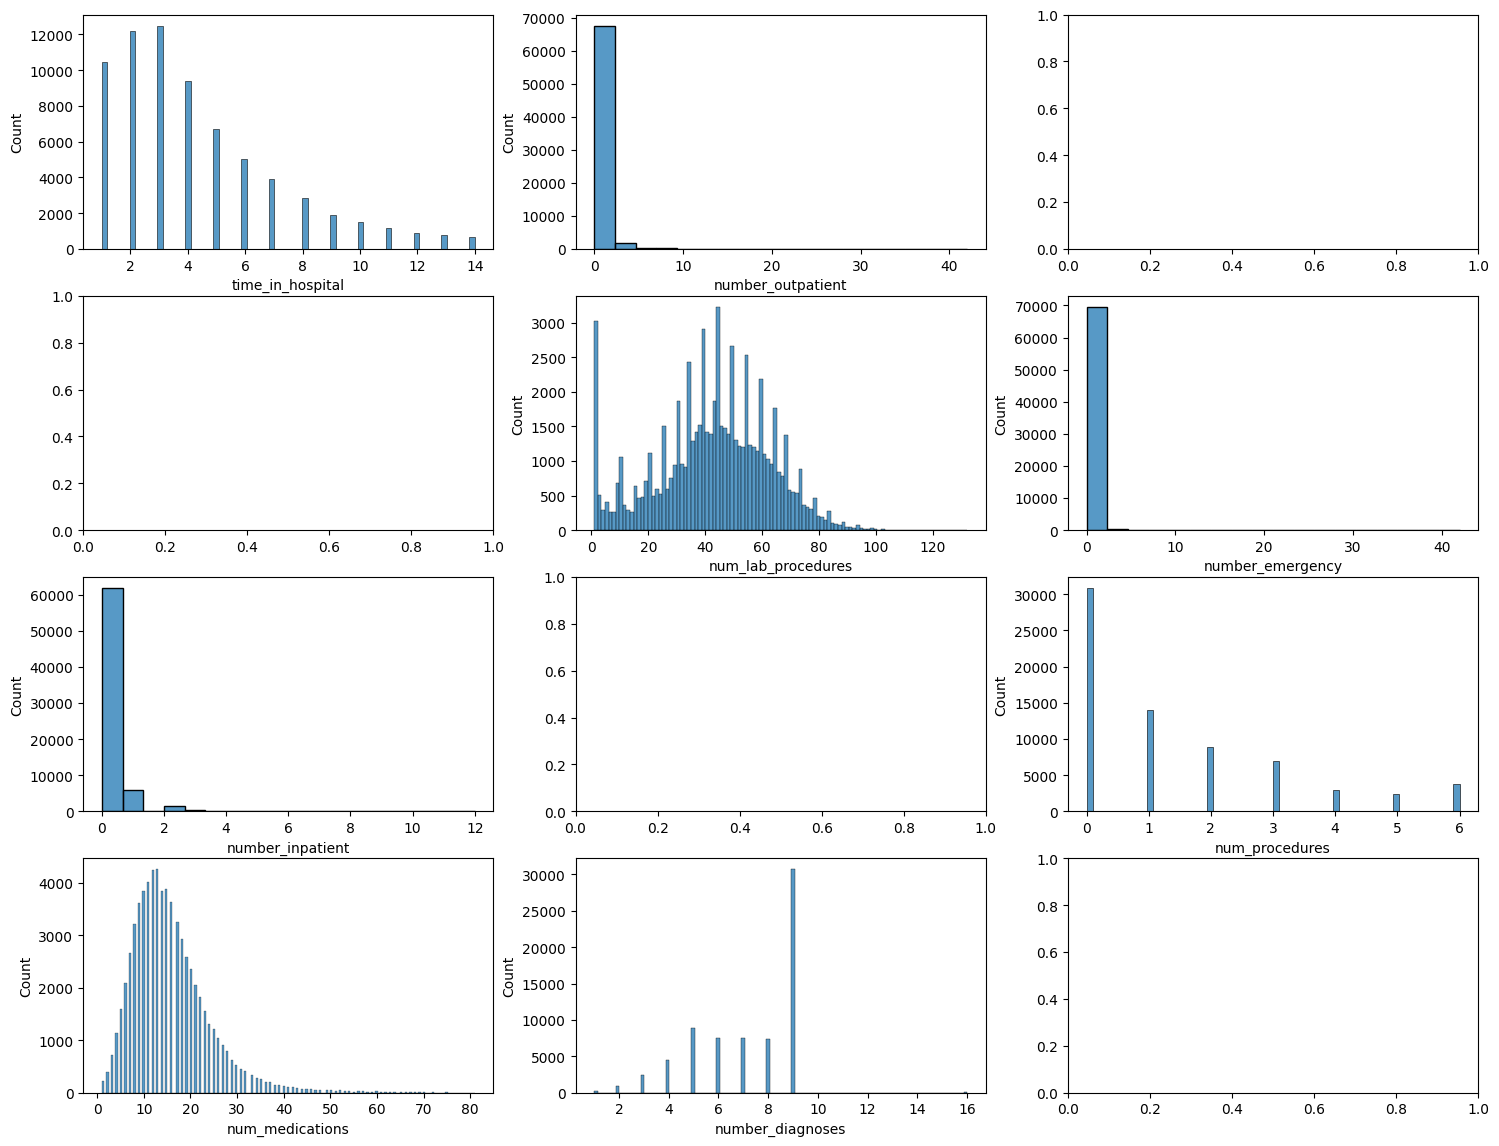

In [164]:
fig, axes = plt.subplots(4, 3, figsize = (18, 14))

i=0
a=0



for col in num_cols:
    i = 0 if i == 3 else i
    a = 0 if a==4 else a
    sns.histplot(df[col], ax = axes[a, i])#.set_title(col)
    
    a+=1
    i+=1

In [179]:
cat_cols

['pioglitazone',
 'rosiglitazone',
 'age',
 'metformin-rosiglitazone',
 'diag_1',
 'metformin-pioglitazone',
 'miglitol',
 'diabetesMed',
 'gender',
 'diag_3',
 'medical_specialty',
 'troglitazone',
 'metformin',
 'citoglipton',
 'insulin',
 'diag_2',
 'A1Cresult',
 'max_glu_serum',
 'weight',
 'acarbose',
 'change',
 'payer_code',
 'race']

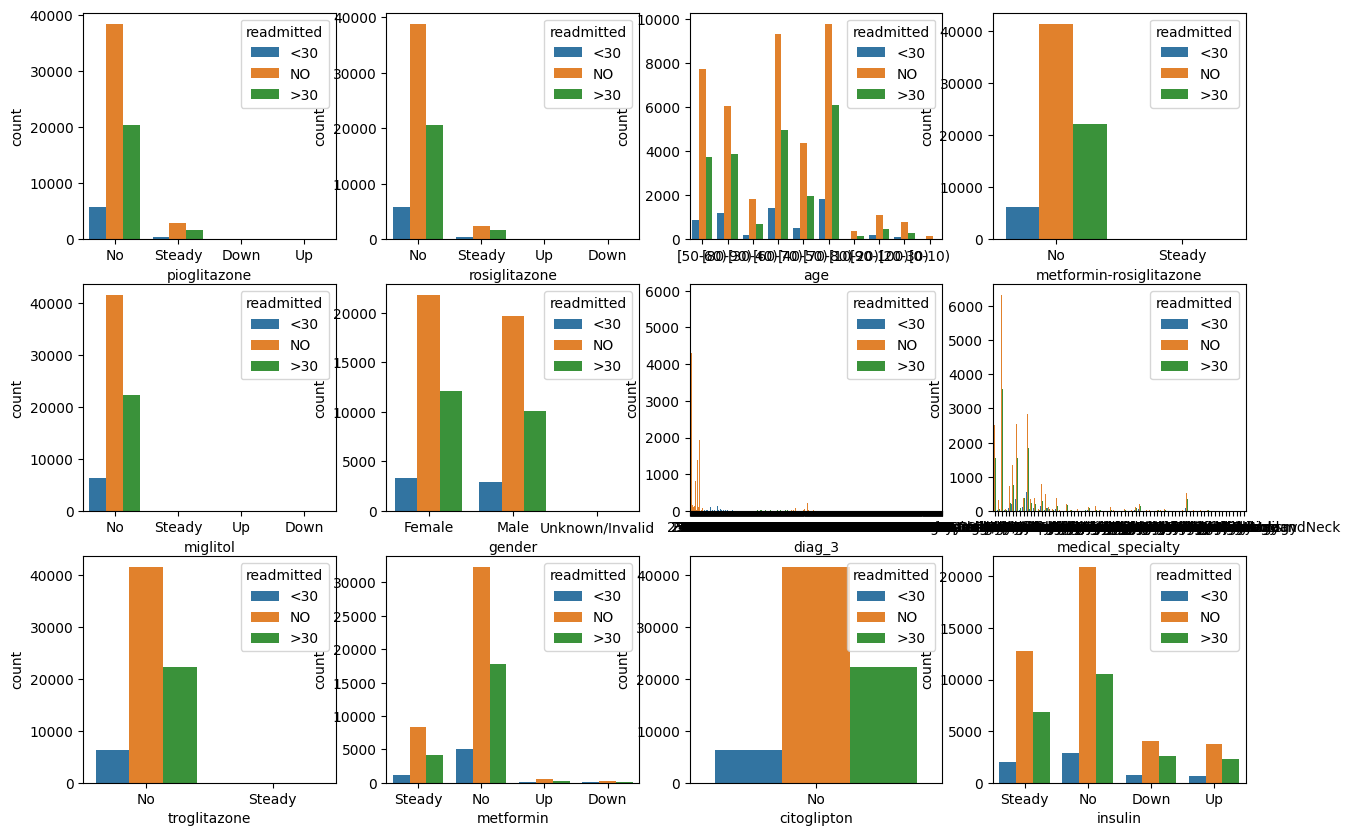

In [192]:
fig, axes = plt.subplots(3, 4, figsize = (15, 10))

sns.countplot(x = 'pioglitazone', data = df, hue = 'readmitted', ax = axes[0, 0]);
sns.countplot(x = 'rosiglitazone', data = df, hue = 'readmitted', ax = axes[0, 1]);
sns.countplot(x = 'metformin-rosiglitazone', data = df, hue = 'readmitted', ax = axes[0, 3]);
sns.countplot(x = 'miglitol', data = df, hue = 'readmitted', ax = axes[1, 0]);
sns.countplot(x = 'gender', data = df, hue = 'readmitted', ax = axes[1, 1]);
sns.countplot(x = 'troglitazone', data = df, hue = 'readmitted', ax = axes[2, 0]);
sns.countplot(x = 'metformin', data = df, hue = 'readmitted', ax = axes[2, 1]);
sns.countplot(x = 'citoglipton', data = df, hue = 'readmitted', ax = axes[2, 2]);
sns.countplot(x = 'insulin', data = df, hue = 'readmitted', ax = axes[2, 3]);


In [ ]:
fig, axes = plt.subplots(4, 2, figsize = (25, 16))

sns.countplot(x = 'age', data = df, hue = 'readmitted', ax = axes[0, 0]);
sns.countplot(x = 'medical_specialty', data = df, hue = 'readmitted', ax = axes[0, 1]);
sns.countplot(x = 'medical_specialty', data = df, hue = 'readmitted', ax = axes[1, 0]);
sns.countplot(x = 'diag_3', data = df, hue = 'readmitted', ax = axes[1, 1]);

IndexError: ignored

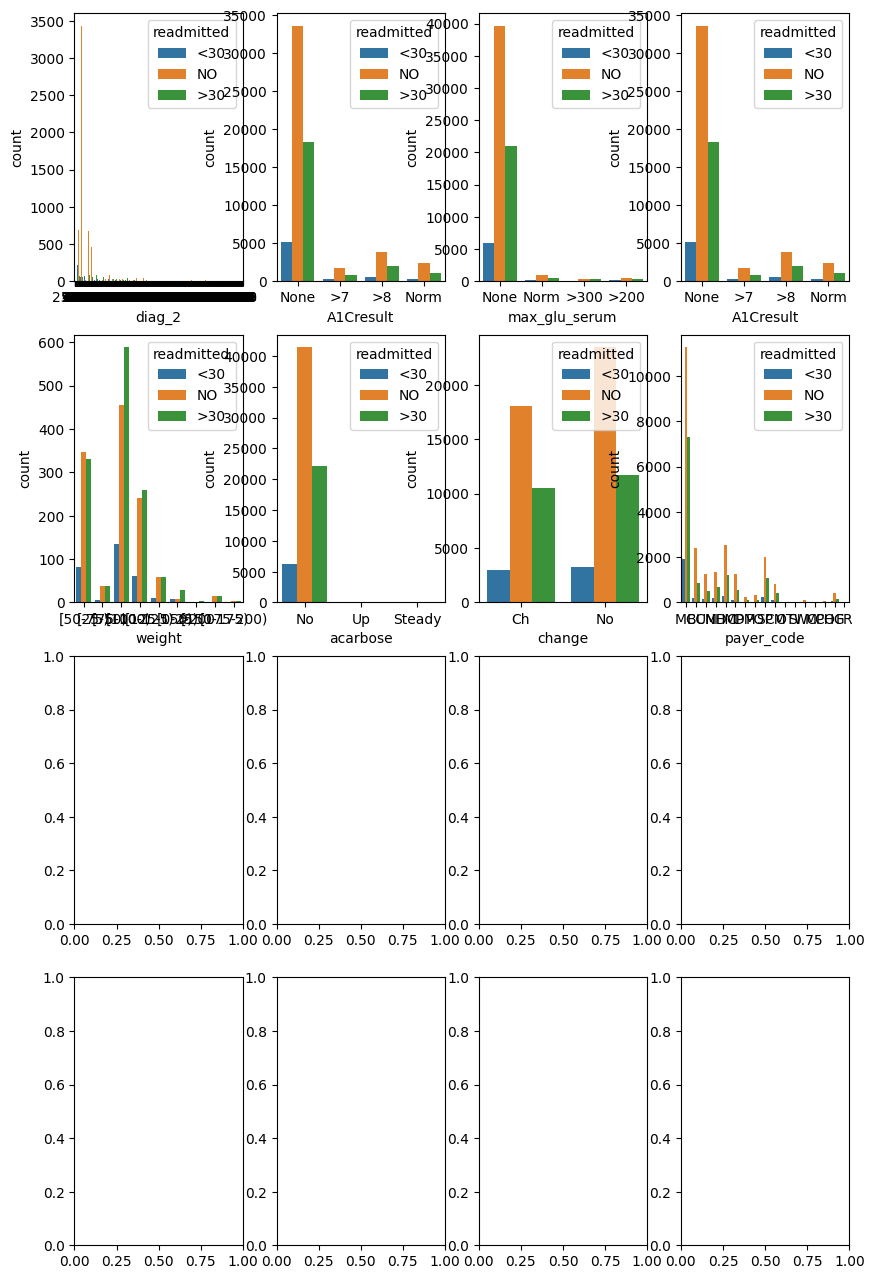

In [193]:
fig, axes = plt.subplots(4, 4, figsize = (10, 16))

sns.countplot(x = 'diag_2', data = df, hue = 'readmitted', ax = axes[0, 0]);
sns.countplot(x = 'A1Cresult', data = df, hue = 'readmitted', ax = axes[0, 1]);
sns.countplot(x = 'max_glu_serum', data = df, hue = 'readmitted', ax = axes[0, 2]);
sns.countplot(x = 'A1Cresult', data = df, hue = 'readmitted', ax = axes[0, 3]);
sns.countplot(x = 'weight', data = df, hue = 'readmitted', ax = axes[1, 0]);
sns.countplot(x = 'acarbose', data = df, hue = 'readmitted', ax = axes[1, 1]);
sns.countplot(x = 'change', data = df, hue = 'readmitted', ax = axes[1, 2]);
sns.countplot(x = 'payer_code', data = df, hue = 'readmitted', ax = axes[1, 3]);
sns.countplot(x = 'race', data = df, hue = 'readmitted', ax = axes[4, 0]);

KeyError: ignored

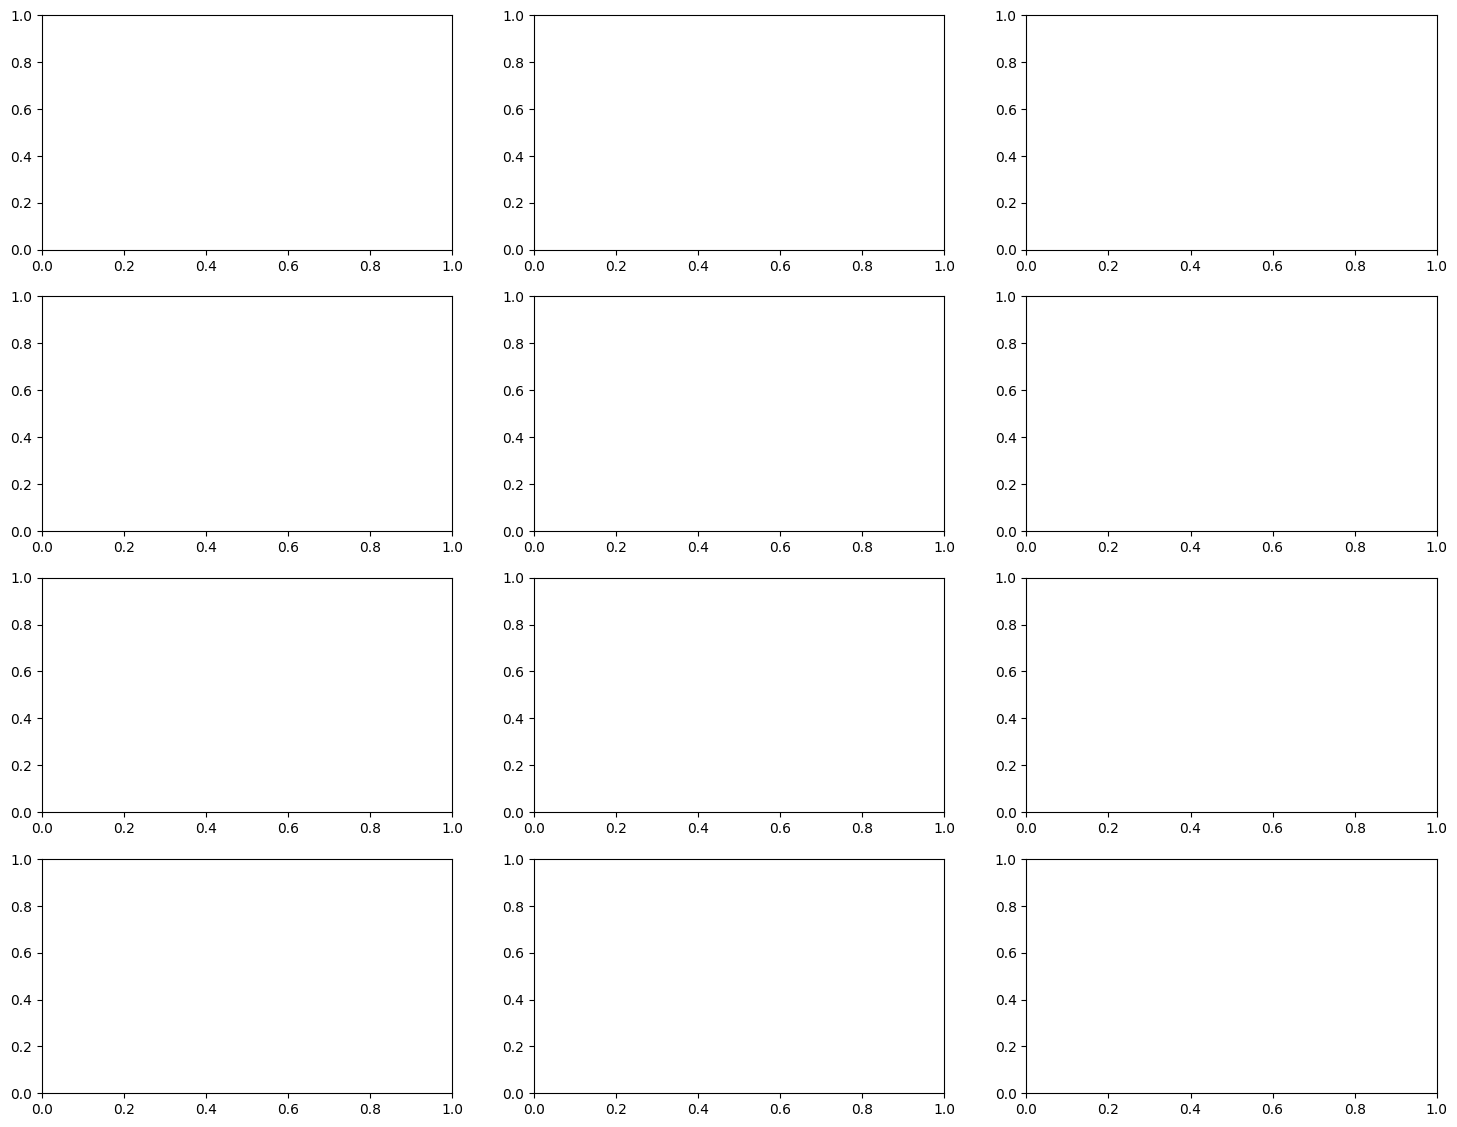

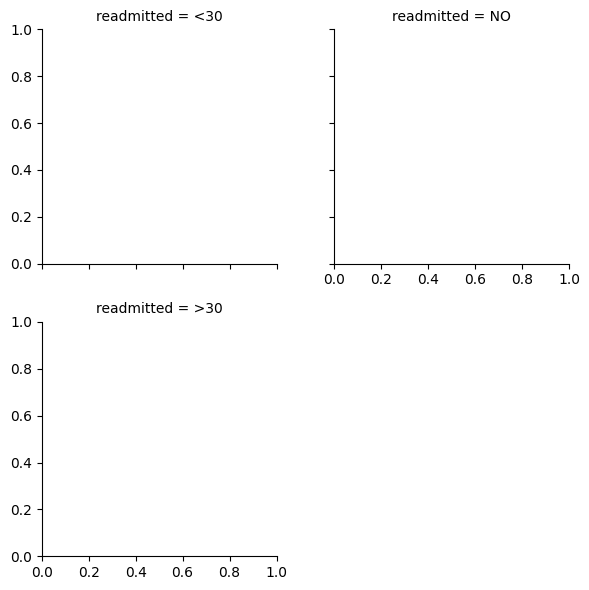

In [174]:
fig, axes = plt.subplots(4, 3, figsize = (18, 14))

i=0
a=0



for col in num_cols:
    i = 0 if i == 3 else i
    a = 0 if a==4 else a
    sns.FacetGrid(data=df, col='readmitted', col_wrap=2)
    g.map(sns.histplot, num_cols)
    
    a+=1
    i+=1

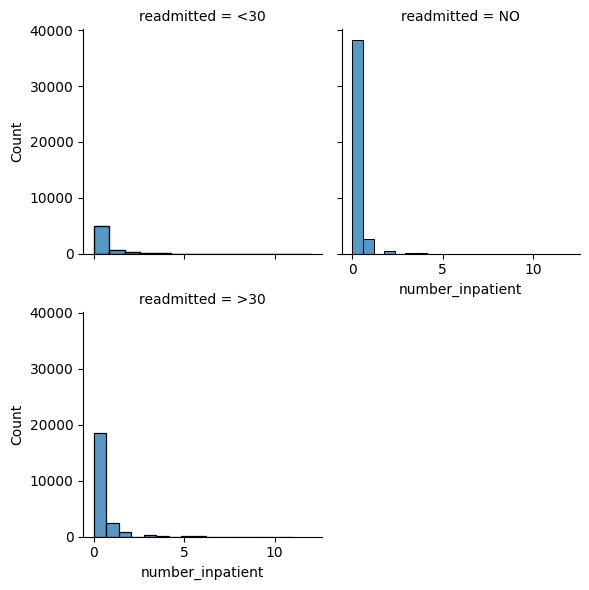

In [165]:
g = sns.FacetGrid(data=df, col='readmitted', col_wrap=2)
g.map(sns.histplot, 'number_inpatient')

In [156]:
df[['readmitted','diag_1']].groupby('diag_1').describe()

readmitted                 
            count unique  top freq
diag_1                            
10              1      1   NO    1
11              8      2   NO    6
110             2      2   NO    1
112            45      3   NO   21
114             1      1  >30    1
...           ...    ...  ...  ...
V60             1      1  <30    1
V63             6      3   NO    4
V67             1      1  >30    1
V70             1      1   NO    1
V71             8      2   NO    7

[694 rows x 4 columns]

In [144]:
#filtering out expired and hospice patients
df = df[df["discharge_description"] != 'Expired']
df = df[df["discharge_description"] != 'Expired at home. Medicaid only, hospice.']
df = df[df["discharge_description"] != 'Hospice / home']
df = df[df["discharge_description"] != 'Hospice / medical facility']

In [145]:
df[['readmitted','change']].groupby('change').describe()

readmitted                  
            count unique top   freq
change                             
Ch          31489      3  NO  18047
No          38474      3  NO  23428

In [146]:
df[['readmitted','admission_description']].groupby('admission_description').describe()

readmitted                  
                           count unique top   freq
admission_description                             
Elective                   13846      3  NO   8915
Emergency                  35671      3  NO  20777
Newborn                        9      3  NO      6
Not Available               3121      3  NO   1783
Not Mapped                   291      3  NO    201
Trauma Center                 18      1  NO     18
Urgent                     12847      3  NO   7583

Admission code 1-Emergency, 2-Urgent, 3-Elective, 4-Newborn, 5-NotAvailable, 6-NULL, 7-Trauma Center, 8-NotMapped.
For Not Mapped and Null admission categories, the missing payer code is seen on almost all patients. Based on the levels of the payer code category, it would seem as if the missing value corresponds to patients who did not disclose a payment method (insurance or self-pay), which in itself, is a category level.

In [147]:
sum = df[['medical_specialty','readmitted']].groupby('medical_specialty').describe()
print(sum.to_string())

                                     readmitted                  
                                          count unique  top  freq
medical_specialty                                                
AllergyandImmunology                          6      3  >30     3
Anesthesiology                                7      3   NO     4
Anesthesiology-Pediatric                     13      3   NO     9
Cardiology                                 4413      3   NO  2517
Cardiology-Pediatric                          7      3  >30     4
DCPTEAM                                       5      2   NO     4
Dentistry                                     4      2  >30     3
Dermatology                                   1      1  >30     1
Emergency/Trauma                           4434      3   NO  2532
Endocrinology                                99      3   NO    63
Endocrinology-Metabolism                      7      2   NO     6
Family/GeneralPractice                     5238      3   NO  2832
Gastroente

In [148]:
len(df)

69963

In [149]:
df.readmitted.value_counts()
# >30 does not count as within 30 days for our target, will replace

NO     41475
>30    22212
<30     6276
Name: readmitted, dtype: int64

In [150]:
y = df.readmitted.replace(to_replace='>30',value='NO')
y = label_binarize(y,classes=['NO','<30'])

In [151]:
# Make dataframe for model input
X = df.loc[:, df.columns != 'readmitted']

#remove repeated categorical columns for description, and discharge column, which has some values of the predictor
X = X[X.columns.drop(list(X.filter(regex='discharge')))]
X = X[X.columns.drop(list(X.filter(regex='_description')))]
X = X[X.columns.drop(list(X.filter(regex='id')))]

#one hot encoding categorical variables for model
cols = X.columns
num_cols = X._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

#creating dataframe of categorical columns
cat_df = X[cat_cols]
cat_df = pd.get_dummies(cat_df, columns=cat_df.columns)

#creating dataframe of numeric columns
num_df = X[num_cols]

X=cat_df.join(num_df)


X


,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,age_[0-10),age_[10-20),...,race_Hispanic,race_Other,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
patient_nbr,,,,,,,,,,,,,,,,,,,,,
135,0,1,0,0,0,1,0,0,0,0,...,0,0,8,77,6,33,0,0,0,8
378,0,1,0,0,0,1,0,0,0,0,...,0,0,2,49,1,11,0,0,0,3
729,0,1,0,0,0,1,0,0,0,0,...,0,0,4,68,2,23,0,0,0,9
774,0,1,0,0,0,1,0,0,0,0,...,0,0,3,46,0,20,0,0,0,9
927,0,1,0,0,0,1,0,0,0,0,...,0,0,5,49,0,5,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189351095,0,1,0,0,0,1,0,0,0,0,...,0,0,1,73,1,11,0,0,0,9
189365864,0,1,0,0,0,1,0,0,0,0,...,0,1,3,56,1,8,0,0,0,7
189445127,0,1,0,0,0,0,1,0,0,0,...,0,0,3,39,0,18,0,0,0,9


In [152]:
num_df

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
patient_nbr,,,,,,,,
135,8,77,6,33,0,0,0,8
378,2,49,1,11,0,0,0,3
729,4,68,2,23,0,0,0,9
774,3,46,0,20,0,0,0,9
927,5,49,0,5,0,0,0,3
...,...,...,...,...,...,...,...,...
189351095,1,73,1,11,0,0,0,9
189365864,3,56,1,8,0,0,0,7
189445127,3,39,0,18,0,0,0,9


In [153]:
cat_df

,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,age_[0-10),age_[10-20),...,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other
patient_nbr,,,,,,,,,,,,,,,,,,,,,
135,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
378,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
729,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
774,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
927,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189351095,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
189365864,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
189445127,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [154]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_val, y_train, y_val = train_test_split(
     X, y, random_state=0)

model = LogisticRegression().fit(X_train, y_train)
model.score(X_val, y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9113829969698702

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
Weights = pd.Series(model.coef_[0], index = X.columns)
Weights = pd.DataFrame({'Var':Weights.index, 'Weight':Weights.values})
Weights = Weights.sort_values('Weight')
idx = Weights['Weight'].abs().sort_values(ascending = False).head(20).index
Weights2 = Weights.loc[idx]
Weights2

,Var,Weight
296,diag_1_434,1.034547
1522,medical_specialty_PhysicalMedicineandRehabilit...,0.721894
548,diag_1_786,-0.528059
139,diag_1_250.7,0.476269
579,diag_1_820,0.471514
1508,medical_specialty_Orthopedics,0.435918
708,diag_1_V58,0.420499
963,diag_3_403,0.404227
339,diag_1_486,-0.382243
301,diag_1_440,0.374502
